In [6]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI-HAR/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI-HAR/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [7]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [13]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, concatenate
)
from tensorflow.keras.utils import to_categorical

cnn_lstm_model = Sequential()

# --- CNN 부분 (Feature Extractor) ---
# 입력 형태: (n_timesteps, n_features) -> (128, 9)
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2)) # 시퀀스 길이(timesteps)를 절반으로 줄임

# --- LSTM 부분 (Sequence Analyzer) ---
# CNN을 통과한 특징(feature)들의 시퀀스를 LSTM이 입력받음
cnn_lstm_model.add(LSTM(100))
cnn_lstm_model.add(Dropout(0.5))

# --- 분류기 (Classifier) ---
cnn_lstm_model.add(Dense(100, activation='relu'))
cnn_lstm_model.add(Dense(n_outputs, activation='softmax'))

# --- 2. 모델 컴파일 ---
cnn_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- 3. 모델 요약 확인 ---
cnn_lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,498 (306.63 KB)

 Trainable params: 78,498 (306.63 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model_history_cnn_lstm = cnn_lstm_model.fit(
    X_train,
    y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot)
)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5124 - loss: 1.1154 - val_accuracy: 0.8287 - val_loss: 0.4326
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7890 - loss: 0.5080 - val_accuracy: 0.8593 - val_loss: 0.3571
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8442 - loss: 0.4095 - val_accuracy: 0.9028 - val_loss: 0.2733
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9106 - loss: 0.2398 - val_accuracy: 0.9218 - val_loss: 0.2312
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9254 - loss: 0.2060 - val_accuracy: 0.9177 - val_loss: 0.1874
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9121 - loss: 0.2235 - val_accuracy: 0.9150 - val_loss: 0.2188
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9238 - loss: 0.1931 - val_accuracy: 0.9341 - val_loss: 0.1642
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9398 - loss: 0.1686 - val_accuracy:

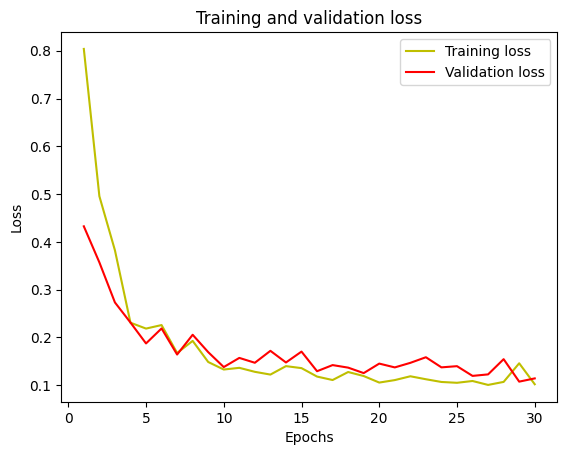

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history_cnn_lstm.history['loss']
val_loss =model_history_cnn_lstm.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

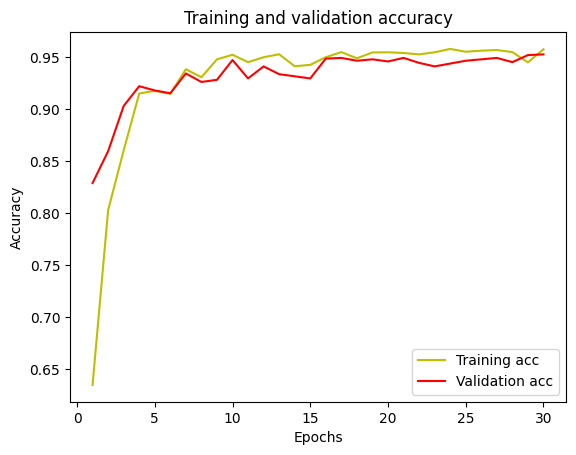

In [16]:
acc =model_history_cnn_lstm.history['accuracy']
val_acc =model_history_cnn_lstm.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

31/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_47
Received: inputs=('Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))')
  warnings.warn(msg)


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_47
Received: inputs=('Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))')
  warnings.warn(msg)


[[446  38  12   0   0   0]
 [  1 444  26   0   0   0]
 [  2   5 413   0   0   0]
 [  0   8   0 413  70   0]
 [  2   0   0 106 424   0]
 [  0  27   0   0   0 510]]
0.8992195453003053
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       496
           1       0.85      0.94      0.89       471
           2       0.92      0.98      0.95       420
           3       0.80      0.84      0.82       491
           4       0.86      0.80      0.83       532
           5       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

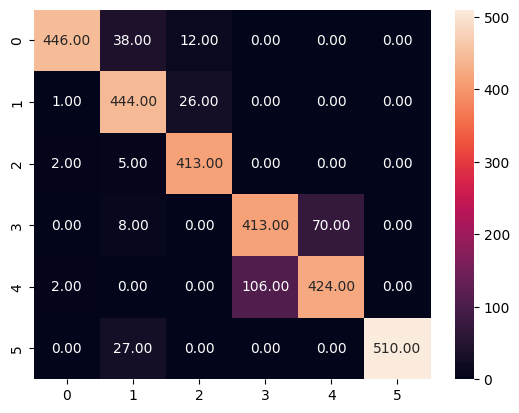

In [17]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=cnn_lstm_model.predict([testX,testX,testX,testX])
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')